In [137]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Machine Learning Engineering Nanodegree
## Project: Onde devo gastar o meu dinheiro?

## Criando base de dados

O objetivo é criar uma tabela contendo dados do crescimento do IFDM de 2012 em relação a 2011, população das cidades e gastos das cidades em cada uma das subáreas. A tabela objetivo está rotulada como gastos_ifdm_dif.

In [138]:
# Importando bases de dados

import numpy as np
import pandas as pd
from IPython.display import display

# Gastos por funcao no ano de 2012
gastos_2012 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2012.csv", encoding="utf-8")

# Codigos de identificacao dos estados e municipios
codigo_municipio = pd.read_csv("Data/Codigo municipal/CodMun2012.csv", encoding='utf-8')
codigo_estado = pd.read_csv("Data/Codigo UF/CodUF2012.csv", encoding='utf-8')

# IFDM por categoria de 2005 a 2013
ifdm_geral_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_geral_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_saude_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_saude_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_empregoRenda_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_empregoRenda_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_educacao_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_educacao_2005-2013.csv", encoding="utf_8", sep=";")

# Metricas municipais em 2010 (IDH)
municipios_metricas = pd.read_csv("Data/Municipios/municipios.csv", encoding="utf-8", sep=";", decimal=",")

In [139]:
# Criando uma tabela para consulta de cidade e estado
estado_municipio = pd.merge(codigo_municipio, codigo_estado, how='inner', left_on=["CD_UF"], right_on=["CD_UF"])

In [140]:
# Filtra apenas os municipios com metricas mais recentes e busca apenas as colunas de interesse
municipio_populacao = municipios_metricas.loc[municipios_metricas['ANO'] == municipios_metricas['ANO'].max(), ['Municipio','UF','POP']]

# Trocando codigo de estado pelo nome do estado em municipio_ 
municipio_populacao = codigo_estado.merge(municipio_populacao, left_on=["CD_UF"], right_on=["UF"])
municipio_populacao.drop(['CD_UF', 'UF_y', 'ESTADO'], axis = 1, inplace = True)
municipio_populacao.rename(columns={'UF_x':'UF', 'POP':'Populacao'}, inplace=True)

display(municipio_populacao.head())

UF              Municipio  Populacao
0  RO  ALTA FLORESTA D'OESTE      24097
1  RO              ARIQUEMES      89766
2  RO                 CABIXI       6303
3  RO                 CACOAL      78141
4  RO             CEREJEIRAS      16942

In [141]:
# Cria tabela de porcentagens de gastos pelo total de gastos
uf_cod_mun = gastos_2012.loc[:,['UF','Cod Mun']]

gastos_2012 = gastos_2012.drop(['UF','Cod Mun'], axis=1)
total_gastos = gastos_2012.pop('Total Geral da Despesa por Funcao')

gastos_2012_percent = gastos_2012.div(total_gastos, axis=0)

# Remonta tabela de gastos inicial
gastos_2012_mun = pd.concat([gastos_2012, total_gastos, uf_cod_mun], axis=1)

# Concatena gastos ao municipio
gastos_2012_mun_percent = pd.concat([gastos_2012_percent, uf_cod_mun], axis=1)

In [142]:
# Adicionando nome da cidade e estado à tabela de gastos_2012
gastos_2012_mun_percent = gastos_2012_mun_percent.merge(estado_municipio, how='inner', left_on=["Cod Mun", "UF"], right_on=["CD_MUN", "CD_UF"])
gastos_2012_mun_percent.drop(['CD_UF', 'CD_MUN', 'UF_x', 'Cod Mun', 'ESTADO'], axis = 1, inplace = True)
gastos_2012_mun_percent.rename(columns={'UF_y':'UF', 'MUNICIPIO':'Municipio'}, inplace=True)

In [143]:
# Criando tabela de IFDM 
conditions = ['Codigo','Regiao','UF','Municipio']
ifdm = ifdm_geral_ano_base_2005_2013.merge(ifdm_saude_ano_base_2005_2013,on=conditions).merge(ifdm_empregoRenda_ano_base_2005_2013,on=conditions).merge(ifdm_educacao_ano_base_2005_2013,on=conditions)

# Removendo cidades sem algum valor de IFDM em algum ano
ifdm = ifdm.dropna()

# Calcula diferença do IFDM de 2012 e 2011
ifdm['ifdm_dif_saude'] = ifdm['2012_saude_nota'] - ifdm['2011_saude_nota']
ifdm['ifdm_dif_empregoRenda'] = ifdm['2012_empregoRenda_nota'] - ifdm['2011_empregoRenda_nota']
ifdm['ifdm_dif_educacao'] = ifdm['2012_educacao_nota'] - ifdm['2011_educacao_nota']
ifdm['ifdm_dif_geral'] = ifdm['2012_geral_nota'] - ifdm['2011_geral_nota']

# Filtra apenas colunas de interesse
ifdm_dif = ifdm[['Municipio','UF','Regiao','ifdm_dif_saude','ifdm_dif_empregoRenda','ifdm_dif_educacao','ifdm_dif_geral','2012_saude_nota','2012_empregoRenda_nota','2012_educacao_nota','2012_geral_nota']]

In [144]:
def remove_acentos(df, coluna):
    sem_acentos = df[coluna].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df.loc[:,coluna] = sem_acentos
    return df

# remove acentos dos nomes das cidades
gastos_2012_mun_percent = remove_acentos(gastos_2012_mun_percent, "Municipio")
ifdm_dif = remove_acentos(ifdm_dif, "Municipio")
municipio_populacao = remove_acentos(municipio_populacao, "Municipio")

In [145]:
def letras_minusculas(df, coluna):
    minusculas = df[coluna].str.lower()
    df.loc[:,coluna] = minusculas
    return df

# Coloca todas as cidades em letras minusculas
gastos_2012_mun_percent = letras_minusculas(gastos_2012_mun_percent, "Municipio")
ifdm_dif = letras_minusculas(ifdm_dif, "Municipio")
municipio_populacao = letras_minusculas(municipio_populacao, "Municipio")

In [146]:
# Adiciona ifdm_dif a tabela de gastos
## TODO: checar a diferenca de municipios esperada (algo perto de 5560 para a obtida de 4733)
gastos_ifdm_dif = ifdm_dif.merge(gastos_2012_mun_percent, on=["Municipio","UF"])

# Renomeia algumas colunas
gastos_ifdm_dif.rename(columns={'Demais Subfuncoes 10':'Demais Subfuncoes Saude', 'Demais Subfuncoes 11':'Demais Subfuncoes Emprego','Demais Subfuncoes 12':'Demais Subfuncoes Educacao'}, inplace=True)

# Filtra features relacionadas a investimentos em trabalho, saude e educacao
gastos_ifdm_dif = gastos_ifdm_dif.loc[:,['ifdm_dif_saude','ifdm_dif_empregoRenda','ifdm_dif_educacao','ifdm_dif_geral','2012_saude_nota','2012_empregoRenda_nota','2012_educacao_nota','2012_geral_nota','Regiao','UF','Municipio','Saude','Atencao Basica','Assistencia Hospitalar','Suporte Profilatico','Vigilancia Sanitaria','Vigilancia Epidemiologica','Alimentacao e Nutricao','Demais Subfuncoes Saude','Trabalho','Protecao ao Trabalhador','Relacoes de Trabalho','Empregabilidade','Fomento ao Trabalho','Demais Subfuncoes Emprego','Educacao','Ensino Fundamental','Ensino Medio','Ensino Profissional','Ensino Superior','Educacao Infantil','Educacao de Jovens e Adultos','Educacao Especial','Demais Subfuncoes Educacao']]

In [147]:
# Adiciona populacao a tabela de gastos
gastos_ifdm_dif = gastos_ifdm_dif.merge(municipio_populacao, on=["Municipio","UF"])

display(gastos_ifdm_dif.head())

ifdm_dif_saude  ifdm_dif_empregoRenda  ifdm_dif_educacao  ifdm_dif_geral  \
0          0.0188                 0.0071            -0.0499         -0.0080   
1          0.0096                -0.0136             0.0509          0.0156   
2          0.0285                 0.0091             0.0048          0.0141   
3          0.0376                 0.0589             0.0128          0.0364   
4         -0.0265                 0.2018            -0.0096          0.0553   

   2012_saude_nota  2012_empregoRenda_nota  2012_educacao_nota  \
0           0.5759                  0.4499              0.6329   
1           0.8373                  0.6393              0.7606   
2           0.6419                  0.4650              0.7462   
3           0.8258                  0.7353              0.7169   
4           0.5596                  0.6370              0.7308   

   2012_geral_nota Regiao  UF    ...      Educacao  Ensino Fundamental  \
0           0.5529  Norte  RO    ...      0.274639            0.262958   
1           0.7457  Norte  RO    ...      0.349965            0.255520   
2           0.6177  Norte  RO    ...      0.322385            0.301011   
3           0.7593  Norte  RO    ...      0.241181            0.160456   
4           0.6425  Norte  RO    ...      0.236343            0.194852   

   Ensino Medio  Ensino Profissional  Ensino Superior  Educacao Infantil  \
0      0.000000                  0.0         0.000000           0.011680   
1      0.000000                  0.0         0.000047           0.020875   
2      0.000000                  0.0         0.000000           0.021373   
3      0.000000                  0.0         0.000000           0.052628   
4      0.013269                  0.0         0.000000           0.027081   

   Educacao de Jovens e Adultos  Educacao Especial  \
0                      0.000000           0.000000   
1                      0.003275           0.000000   
2                      0.000000           0.000000   
3                      0.000000           0.000674   
4                      0.000000           0.001141   

   Demais Subfuncoes Educacao  Populacao  
0                    0.000000      24097  
1                    0.070247      89766  
2                    0.000000       6303  
3                    0.027423      78141  
4                    0.000000      16942  

[5 rows x 35 columns]

In [148]:
# Categoriza o tamanho das cidades pela populacao
gastos_ifdm_dif['Tamanho'] = np.where(gastos_ifdm_dif['Populacao'] < 50000, 'Pequena', 
        np.where(gastos_ifdm_dif['Populacao'] < 100000, 'Media-pequena',
                np.where(gastos_ifdm_dif['Populacao'] < 300000, 'Media',
                        np.where(gastos_ifdm_dif['Populacao'] < 500000, 'Media-grande',
                                np.where(gastos_ifdm_dif['Populacao'] < 1000000, 'Grande', 'Metropole')))))

# Análise descritiva


In [149]:
# Dados
display(gastos_ifdm_dif.head())

ifdm_dif_saude  ifdm_dif_empregoRenda  ifdm_dif_educacao  ifdm_dif_geral  \
0          0.0188                 0.0071            -0.0499         -0.0080   
1          0.0096                -0.0136             0.0509          0.0156   
2          0.0285                 0.0091             0.0048          0.0141   
3          0.0376                 0.0589             0.0128          0.0364   
4         -0.0265                 0.2018            -0.0096          0.0553   

   2012_saude_nota  2012_empregoRenda_nota  2012_educacao_nota  \
0           0.5759                  0.4499              0.6329   
1           0.8373                  0.6393              0.7606   
2           0.6419                  0.4650              0.7462   
3           0.8258                  0.7353              0.7169   
4           0.5596                  0.6370              0.7308   

   2012_geral_nota Regiao  UF      ...       Ensino Fundamental  Ensino Medio  \
0           0.5529  Norte  RO      ...                 0.262958      0.000000   
1           0.7457  Norte  RO      ...                 0.255520      0.000000   
2           0.6177  Norte  RO      ...                 0.301011      0.000000   
3           0.7593  Norte  RO      ...                 0.160456      0.000000   
4           0.6425  Norte  RO      ...                 0.194852      0.013269   

   Ensino Profissional  Ensino Superior  Educacao Infantil  \
0                  0.0         0.000000           0.011680   
1                  0.0         0.000047           0.020875   
2                  0.0         0.000000           0.021373   
3                  0.0         0.000000           0.052628   
4                  0.0         0.000000           0.027081   

   Educacao de Jovens e Adultos  Educacao Especial  \
0                      0.000000           0.000000   
1                      0.003275           0.000000   
2                      0.000000           0.000000   
3                      0.000000           0.000674   
4                      0.000000           0.001141   

   Demais Subfuncoes Educacao  Populacao        Tamanho  
0                    0.000000      24097        Pequena  
1                    0.070247      89766  Media-pequena  
2                    0.000000       6303        Pequena  
3                    0.027423      78141  Media-pequena  
4                    0.000000      16942        Pequena  

[5 rows x 36 columns]

In [150]:
# Descricao dos dados pelo tamanho da cidade
g = gastos_ifdm_dif.groupby('Tamanho')

display(g.describe())

2012_educacao_nota  2012_empregoRenda_nota  \
Tamanho                                                           
Grande        count           23.000000               23.000000   
              mean             0.763557                0.743678   
              std              0.122712                0.057770   
              min              0.536900                0.610000   
              25%              0.652550                0.718100   
              50%              0.789400                0.765500   
              75%              0.866900                0.784650   
              max              0.929700                0.814800   
Media         count          186.000000              186.000000   
              mean             0.774097                0.712705   
              std              0.112689                0.103551   
              min              0.526500                0.408800   
              25%              0.686700                0.655650   
              50%              0.787350                0.742000   
              75%              0.864075                0.784500   
              max              0.974300                0.893300   
Media-grande  count           40.000000               40.000000   
              mean             0.772825                0.735743   
              std              0.113910                0.083223   
              min              0.594600                0.522600   
              25%              0.654000                0.703825   
              50%              0.778200                0.764950   
              75%              0.865550                0.796375   
              max              0.969800                0.845500   
Media-pequena count          301.000000              301.000000   
              mean             0.724968                0.622176   
              std              0.130989                0.135833   
              min              0.414400                0.225900   
              25%              0.628700                0.515200   
              50%              0.722800                0.616400   
              75%              0.832400                0.740400   
              max              0.982500                0.874700   
Metropole     count           14.000000               14.000000   
              mean             0.765429                0.767750   
              std              0.098218                0.026429   
              min              0.603100                0.725400   
              25%              0.693950                0.747875   
              50%              0.755250                0.766150   
              75%              0.836100                0.793950   
              max              0.906400                0.801700   
Pequena       count         3920.000000             3920.000000   
              mean             0.723732                0.482491   
              std              0.121651                0.121060   
              min              0.271400                0.121400   
              25%              0.637325                0.396000   
              50%              0.734100                0.466050   
              75%              0.811125                0.561750   
              max              1.000000                0.880300   

                     2012_geral_nota  2012_saude_nota  Alimentacao e Nutricao  \
Tamanho                                                                         
Grande        count        23.000000        23.000000               23.000000   
              mean          0.781257         0.836570                0.000084   
              std           0.069251         0.075541                0.000286   
              min           0.656300         0.679500                0.000000   
              25%           0.728100         0.795900                0.000000   
              50%           0.801800         0.847800                0.000000   
              75%     

In [151]:
# Utilizacao de cidades medias, media-grandes, grandes e metropoles no estudo
cidades_100_mais_hab = gastos_ifdm_dif.loc[gastos_ifdm_dif['Tamanho'].isin(['Metropole','Grande','Media-grande','Media'])]
n_cidades = len(cidades_100_mais_hab)
print "Numero de cidades na base: {}".format(n_cidades)

Numero de cidades na base: 263


In [152]:
print "Cidades por estado: "
print cidades_100_mais_hab['UF'].value_counts()

Cidades por estado: 
SP    73
RJ    23
MG    23
RS    18
PR    17
BA    15
SC    12
PE    12
ES     9
CE     8
GO     8
PA     7
MA     7
PB     4
MT     4
MS     4
RN     3
AL     2
AP     2
SE     2
RO     2
PI     2
TO     2
AM     2
RR     1
AC     1
Name: UF, dtype: int64


In [153]:
print "Cidades por regiao: "
print cidades_100_mais_hab['Regiao'].value_counts()

display(cidades_100_mais_hab.head())

Cidades por regiao: 
Sudeste         128
Nordeste         55
Sul              47
Norte            17
Centro-Oeste     16
Name: Regiao, dtype: int64


ifdm_dif_saude  ifdm_dif_empregoRenda  ifdm_dif_educacao  ifdm_dif_geral  \
11          0.0339                -0.0035             0.0082          0.0128   
16          0.0264                -0.1000             0.0152         -0.0195   
59          0.0232                -0.0261             0.0198          0.0056   
82         -0.0082                -0.0381             0.0076         -0.0130   
87          0.0373                -0.0220             0.0003          0.0052   

    2012_saude_nota  2012_empregoRenda_nota  2012_educacao_nota  \
11           0.6752                  0.7418              0.6866   
16           0.7503                  0.7279              0.6591   
59           0.7610                  0.7639              0.7208   
82           0.6791                  0.7484              0.6490   
87           0.6874                  0.4929              0.7602   

    2012_geral_nota Regiao  UF      ...      Ensino Fundamental  Ensino Medio  \
11           0.7012  Norte  RO      ...                0.196993      0.000000   
16           0.7124  Norte  RO      ...                0.174298      0.000000   
59           0.7485  Norte  AC      ...                0.176190      0.000000   
82           0.6921  Norte  AM      ...                0.214369      0.000000   
87           0.6468  Norte  AM      ...                0.333794      0.000606   

    Ensino Profissional  Ensino Superior  Educacao Infantil  \
11                  0.0         0.001179           0.013021   
16                  0.0         0.000000           0.020425   
59                  0.0         0.000000           0.012034   
82                  0.0         0.002727           0.034156   
87                  0.0         0.000235           0.049651   

    Educacao de Jovens e Adultos  Educacao Especial  \
11                      0.000000           0.000595   
16                      0.002704           0.000128   
59                      0.000000           0.000000   
82                      0.003963           0.000686   
87                      0.000000           0.000000   

    Demais Subfuncoes Educacao  Populacao       Tamanho  
11                    0.003432     115896         Media  
16                    0.032065     422555  Media-grande  
59                    0.000000     333052  Media-grande  
82                    0.010063    1793443     Metropole  
87                    0.012355     101218         Media  

[5 rows x 36 columns]

In [154]:
# Separa so os gastos de cada cidade

gastos = cidades_100_mais_hab.copy()
gastos.drop(['ifdm_dif_saude','ifdm_dif_empregoRenda','ifdm_dif_educacao','ifdm_dif_geral','2012_saude_nota','2012_empregoRenda_nota','2012_educacao_nota','2012_geral_nota','Regiao','UF','Municipio','Tamanho','Populacao'], axis = 1, inplace = True)

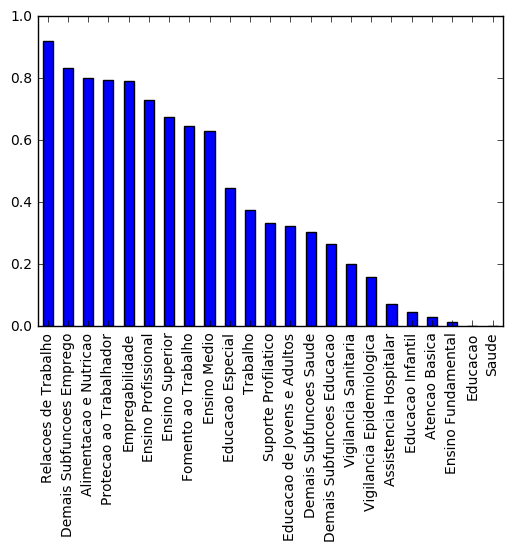

In [155]:
# Print ocorrencias de zeros
total_ocorrencias = gastos[gastos == 0].count()
porcentagem_ocorrencias = total_ocorrencias/n_cidades
porcentagem_ocorrencias = porcentagem_ocorrencias.sort_values(ascending=False)

porcentagem_ocorrencias.plot.bar();

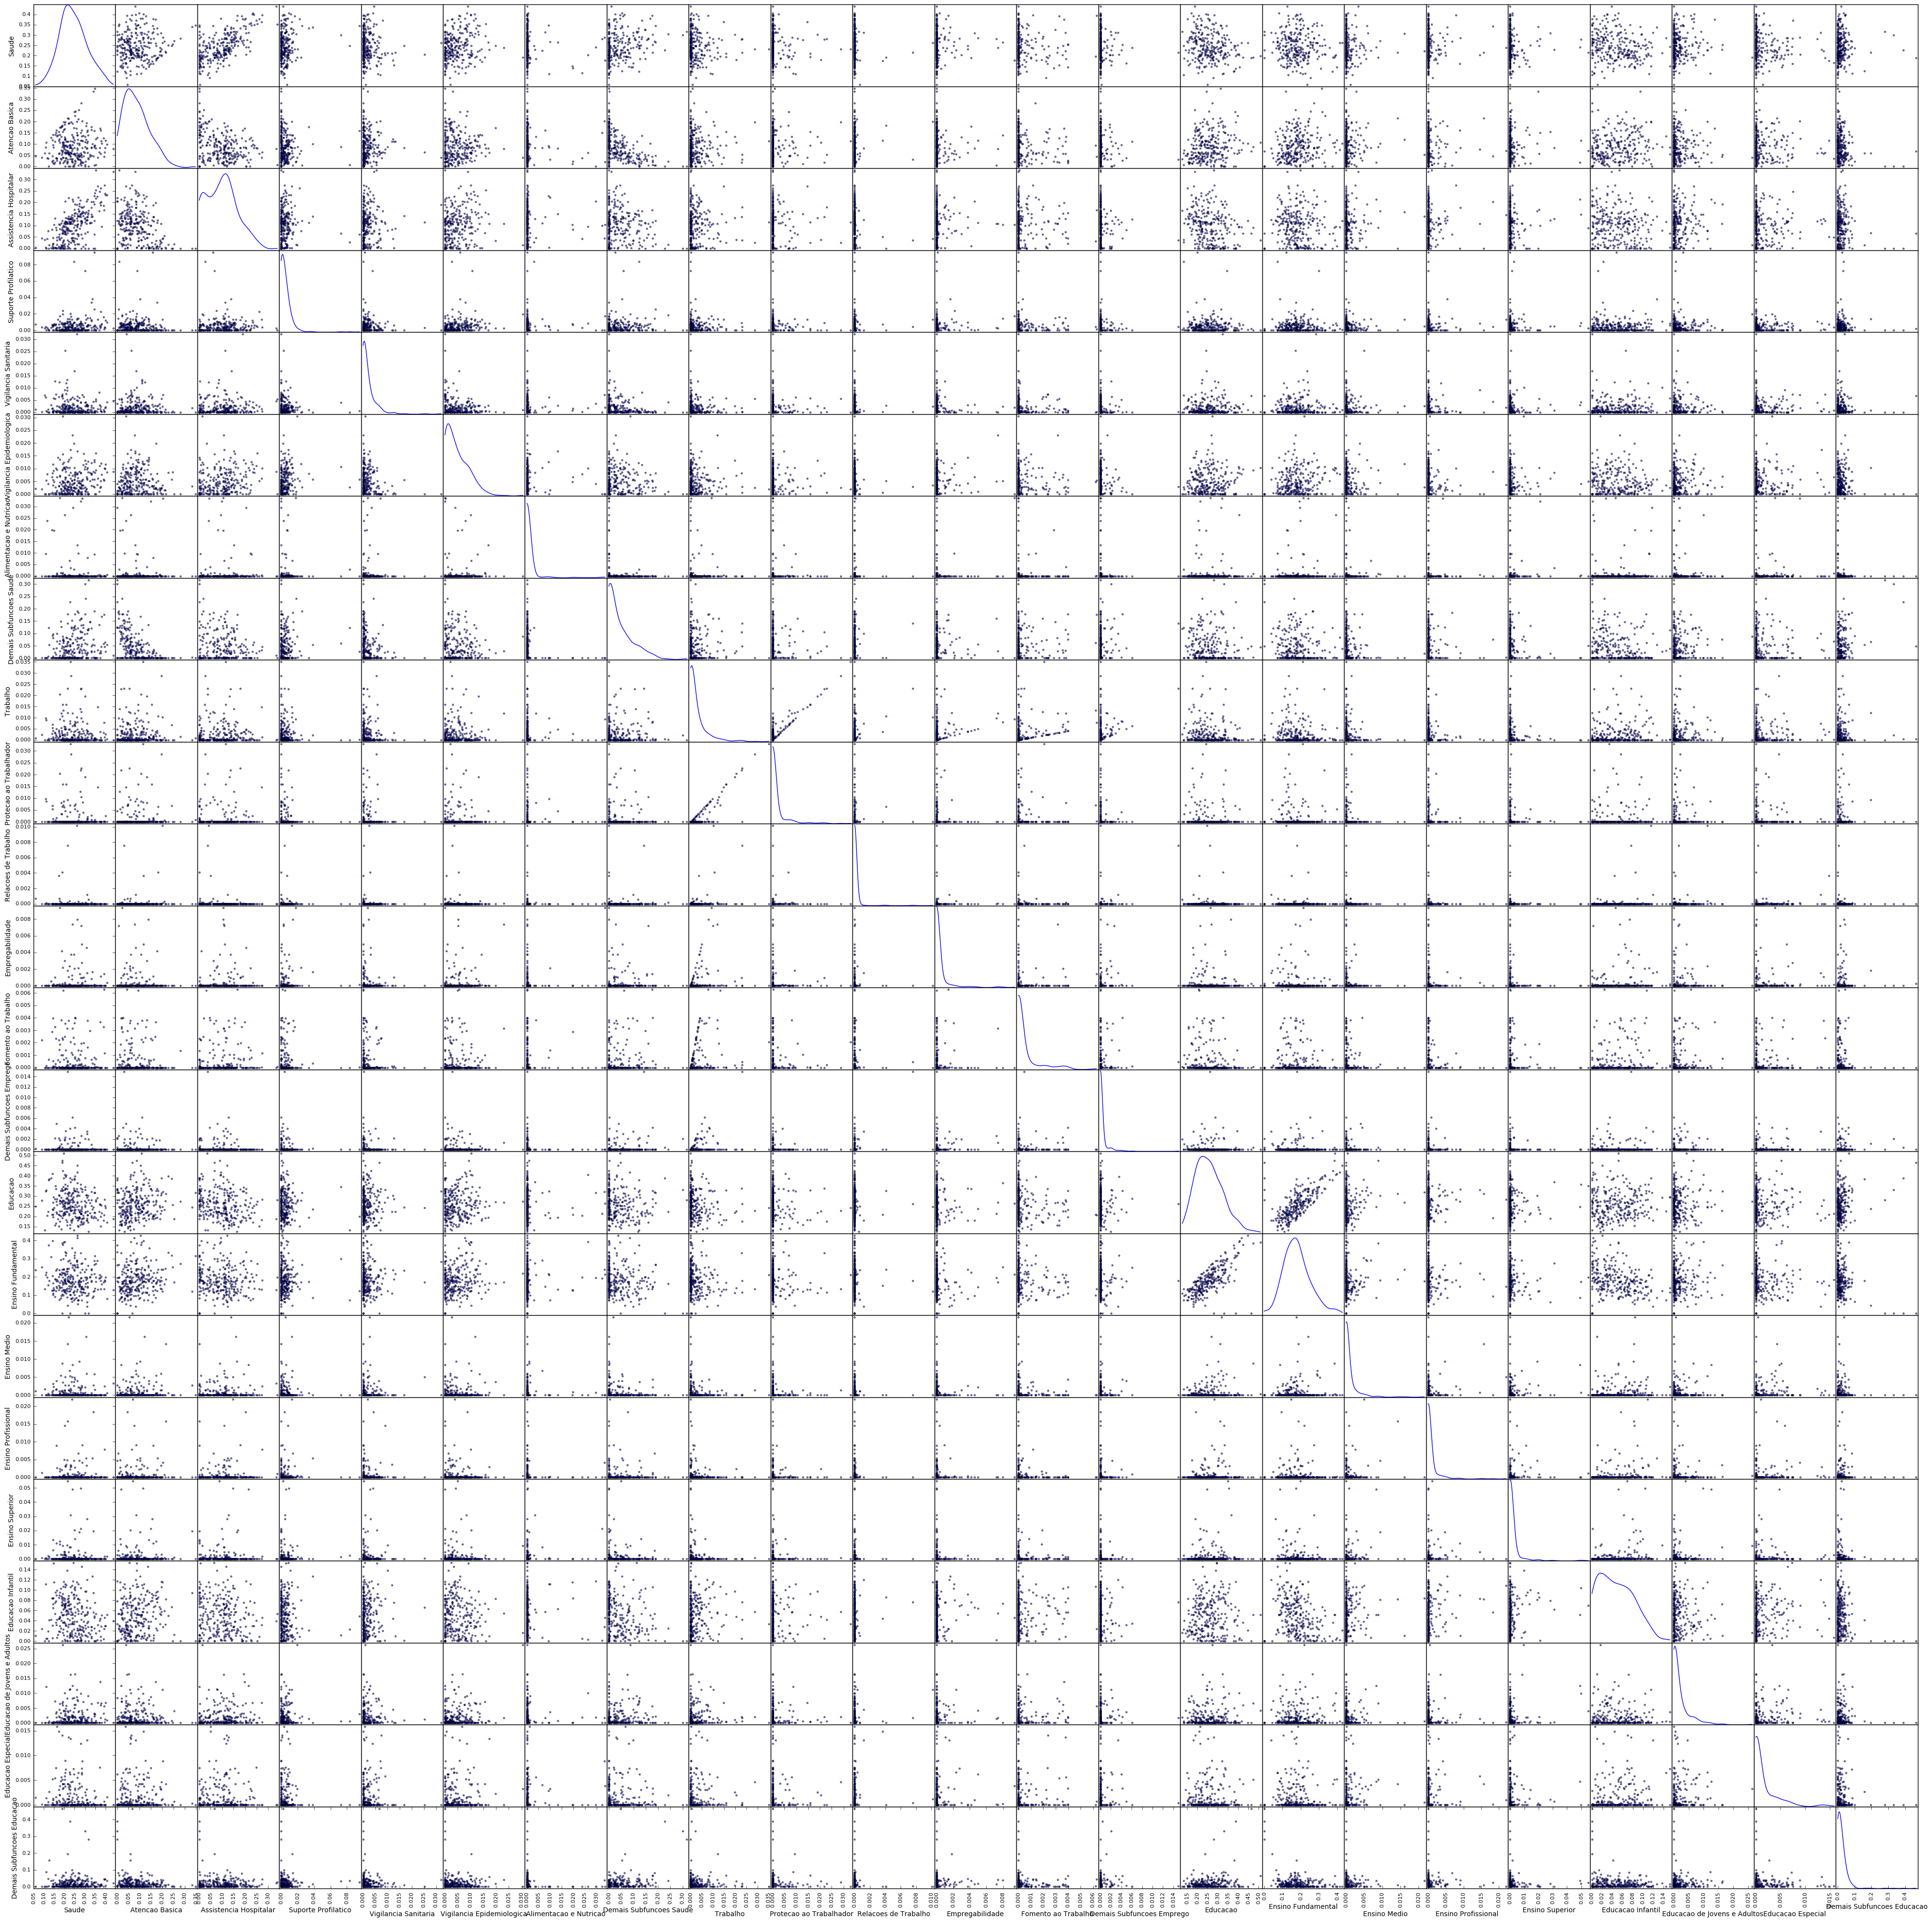

In [156]:
from pandas.tools.plotting import scatter_matrix

# Produz um scatterplot para cada par de features
scatter_matrix(gastos, figsize=(50, 50), diagonal='kde');

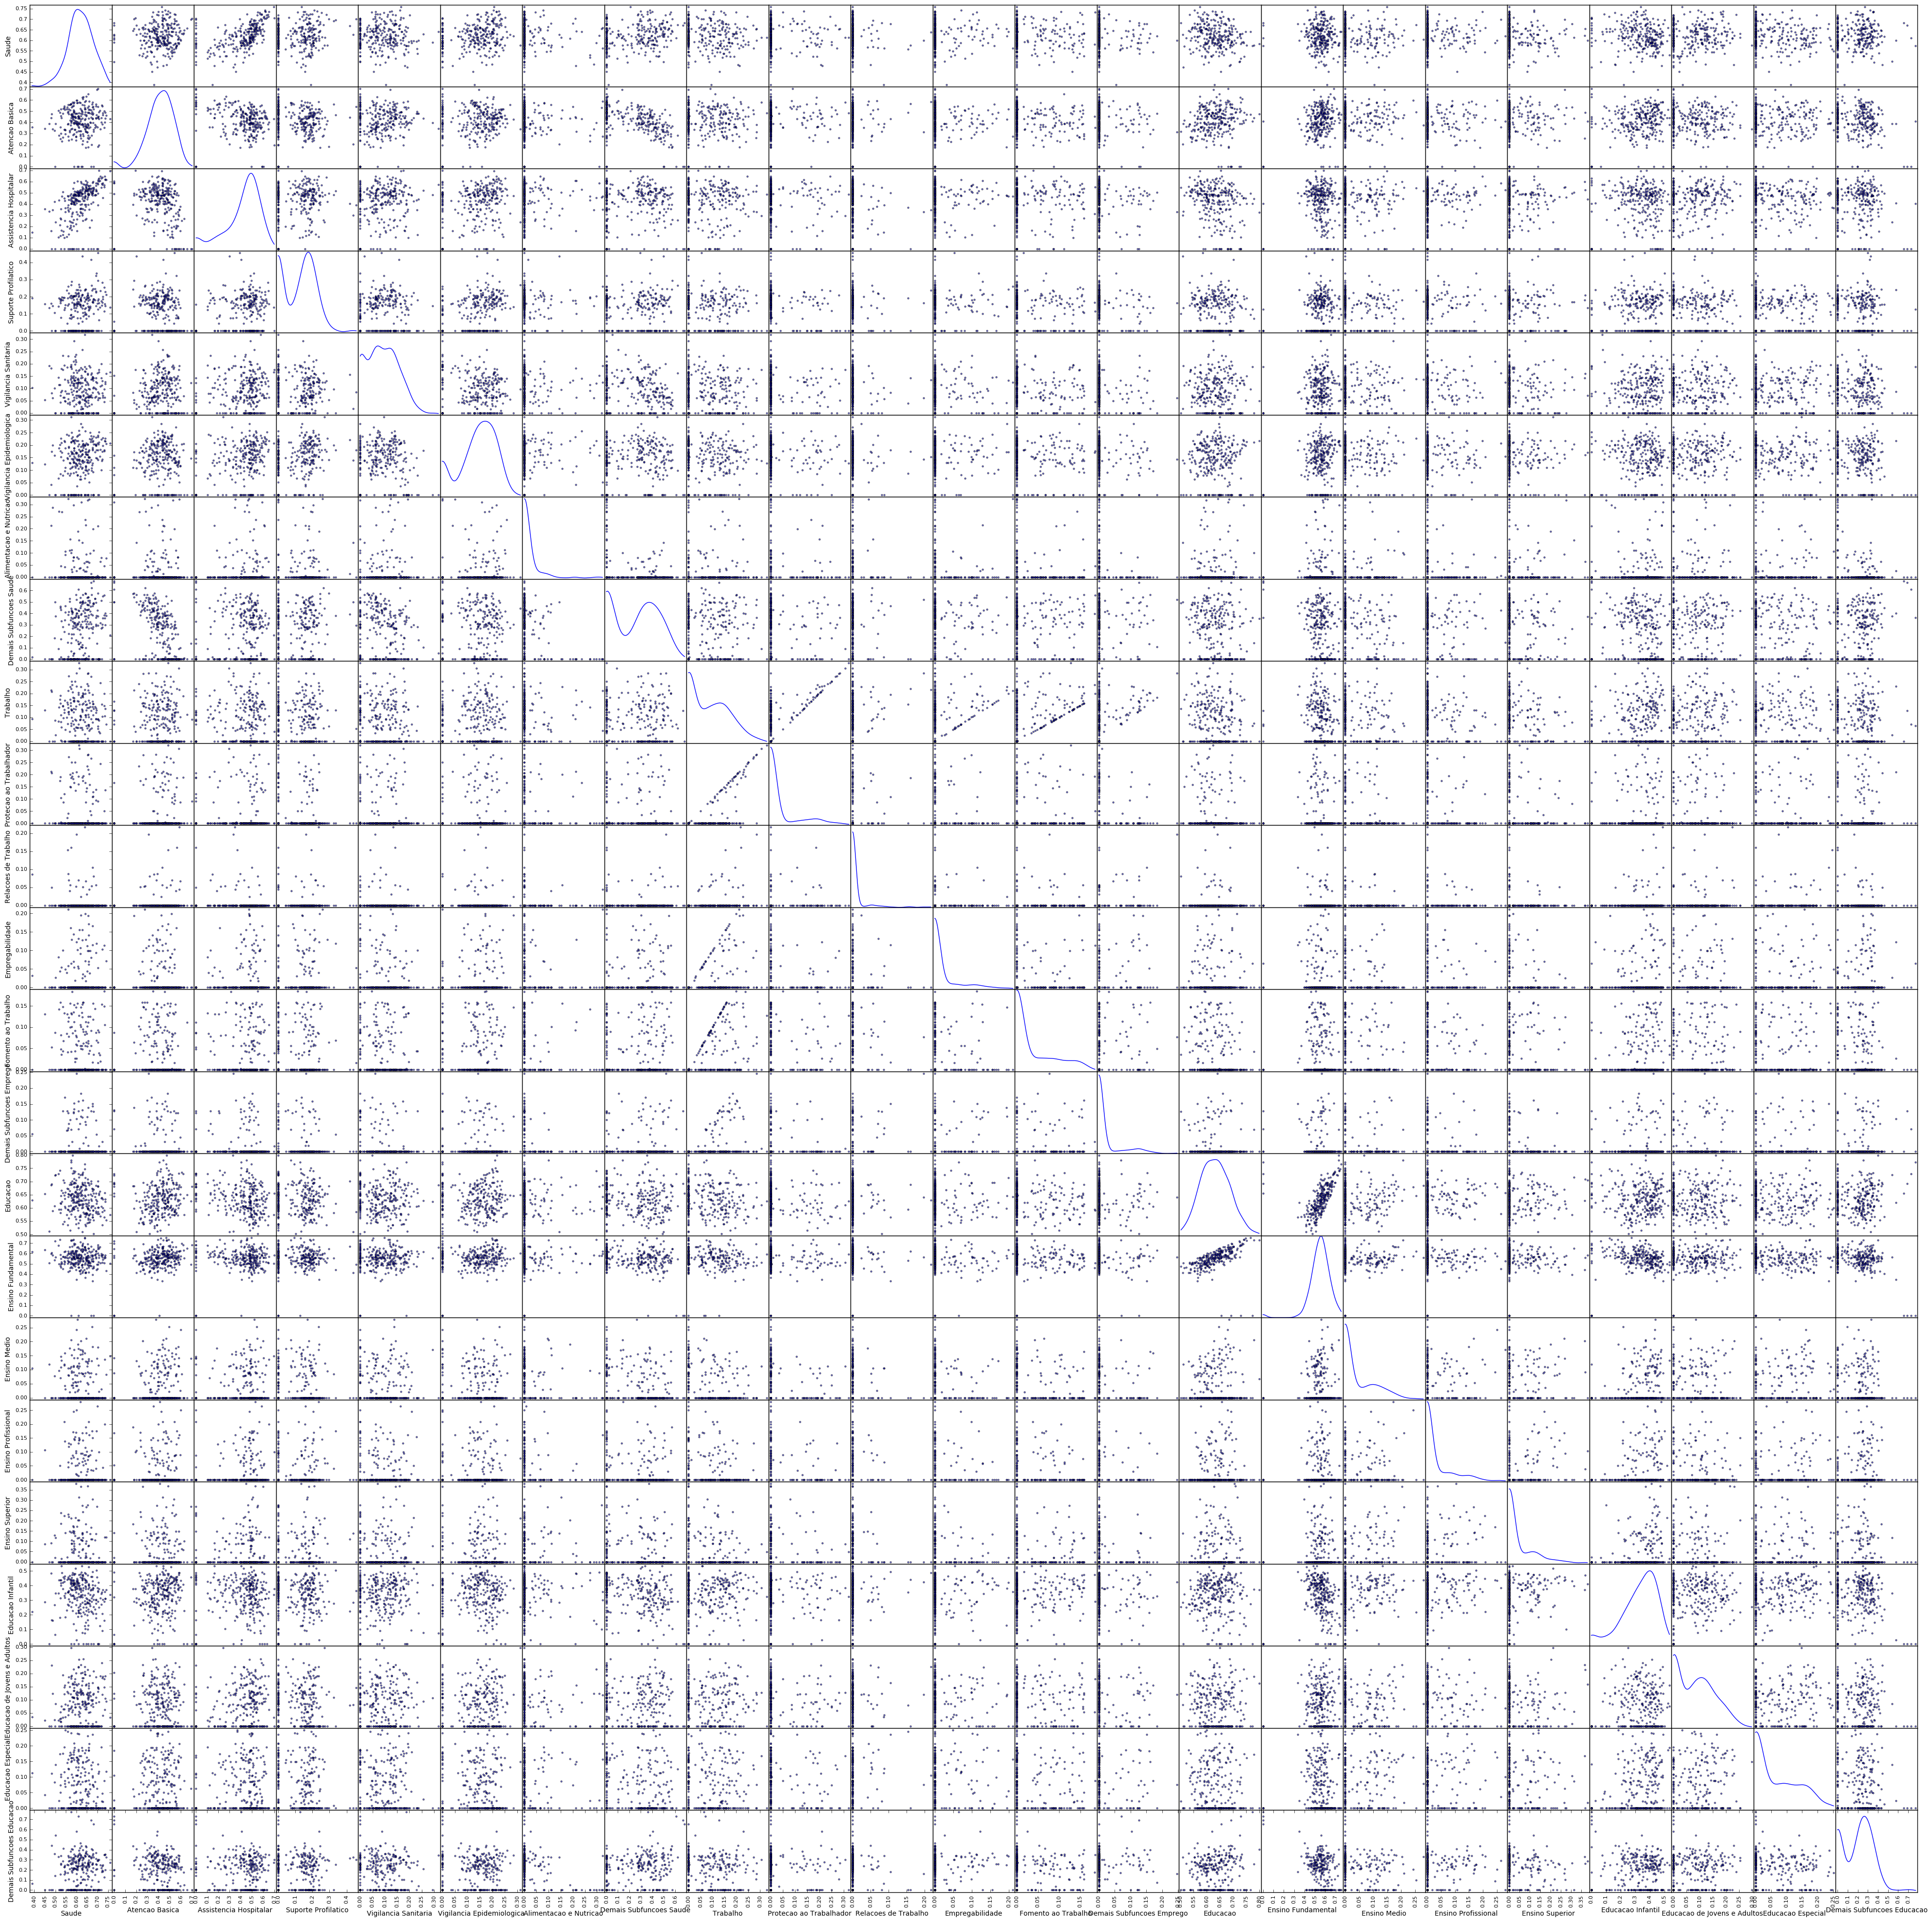

In [157]:
# Transforma os dados utilizando a raiz cubica
cbrt_gastos = np.cbrt(gastos)

# Produz um scatterplot para cada par de features
pd.scatter_matrix(cbrt_gastos, figsize = (50,50), diagonal = 'kde');

In [158]:
list(cidades_100_mais_hab)

['ifdm_dif_saude',
 'ifdm_dif_empregoRenda',
 'ifdm_dif_educacao',
 'ifdm_dif_geral',
 '2012_saude_nota',
 '2012_empregoRenda_nota',
 '2012_educacao_nota',
 '2012_geral_nota',
 'Regiao',
 'UF',
 'Municipio',
 'Saude',
 'Atencao Basica',
 'Assistencia Hospitalar',
 'Suporte Profilatico',
 'Vigilancia Sanitaria',
 'Vigilancia Epidemiologica',
 'Alimentacao e Nutricao',
 'Demais Subfuncoes Saude',
 'Trabalho',
 'Protecao ao Trabalhador',
 'Relacoes de Trabalho',
 'Empregabilidade',
 'Fomento ao Trabalho',
 'Demais Subfuncoes Emprego',
 'Educacao',
 'Ensino Fundamental',
 'Ensino Medio',
 'Ensino Profissional',
 'Ensino Superior',
 'Educacao Infantil',
 'Educacao de Jovens e Adultos',
 'Educacao Especial',
 'Demais Subfuncoes Educacao',
 'Populacao',
 'Tamanho']

In [159]:
# retirando outliers

# Inicianilizando vetor vazio de outliers
data = cbrt_gastos
    
outliers = np.empty(0, dtype=int)
for feature in data.keys():
    
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    
    step = np.multiply(1.5, Q3-Q1)
    
    # Mostra os outliers
    out = data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))]
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(out)
    
    # Select the indices for data points you wish to remove
    outliers = np.append(outliers, out.index.values)

Data points considered outliers for the feature 'Saude':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
1698  0.471843        0.388917                0.332577             0.134263   
3695  0.450297        0.343601                0.355305             0.157067   
4005  0.389136        0.357132                0.146690             0.191116   

      Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
1698              0.191448                   0.000000                     0.0   
3695              0.053914                   0.122837                     0.0   
4005              0.103433                   0.128562                     0.0   

      Demais Subfuncoes Saude  Trabalho  Protecao ao Trabalhador  \
1698                 0.000000  0.000000                      0.0   
3695                 0.000000  0.130531                      0.0   
4005                 0.019541  0.094421                      0.0   

                 ...              Demais Subfuncoes Emprego  Educacao  \
1698             ...                               0.000000  0.511586   
3695             ...                               0.000000  0.653394   
4005             ...                               0.054829  0.629905   

      Ensino Fundamental  Ensino Medio  Ensino Profissional  Ensino Superior  \
1698            0.509418      0.119224              0.00000         0.000000   
3695            0.632546      0.000000              0.10749         0.087461   
4005            0.618100      0.104536              0.00000         0.000000   

      Educacao Infantil  Educacao de Jovens e Adultos  Educacao Especial  \
1698           0.000000                      0.000000           0.000000   
3695           0.287887                      0.021555           0.042746   
4005           0.221496                      0.035248           0.113234   

      Demais Subfuncoes Educacao  
1698                    0.000000  
3695                    0.000000  
4005                    0.065935  

[3 rows x 23 columns]

Data points considered outliers for the feature 'Atencao Basica':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
108   0.682048             0.0                0.000000             0.000000   
608   0.610433             0.0                0.000000             0.000000   
1560  0.669991             0.0                0.000000             0.000000   
2355  0.627187             0.0                0.492791             0.056085   
2592  0.622447             0.0                0.588715             0.000000   
2958  0.604789             0.0                0.603985             0.000000   
4271  0.497731             0.0                0.000000             0.000000   
4384  0.589233             0.0                0.589233             0.000000   

      Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
108               0.000000                   0.000000                 0.00000   
608               0.000000                   0.000000                 0.00000   
1560              0.000000                   0.000000                 0.00000   
2355              0.000000                   0.110269                 0.00000   
2592              0.153092                   0.158022                 0.30929   
2958              0.070163                   0.081220                 0.00000   
4271              0.000000                   0.000000                 0.00000   
4384              0.000000                   0.000000                 0.00000   

      Demais Subfuncoes Saude  Trabalho  Protecao ao Trabalhador  \
108                  0.682048  0.000000                 0.000000   
608                  0.610433  0.071106                 0.000000   
1560                 0.669991  0.127106                 0.000000   
2355                 0.500699  0.130661                 0.000000   
2592                 0.000000  0.000000                 0.000000   
2958                 0.000000  0.000000                 0.000000   
4271                 0.497731  0.086944                 0.000000   
4384                 0.000000  0.166746                 0.166746   

                 ...              Demais Subfuncoes Emprego  Educacao  \
108              ...                               0.000000  0.654825   
608              ...                               0.071106  0.729522   
1560             ...                               0.127106  0.691573   
2355             ...                               0.130661  0.690021   
2592             ...                               0.000000  0.680818   
2958             ...                               0.000000  0.643663   
4271             ...                               0.000000  0.722946   
4384             ...                               0.000000  0.694695   

      Ensino Fundamental  Ensino Medio  Ensino Profissional  Ensino Superior  \
108             0.000000      0.000000             0.000000         0.000000   
608             0.000000      0.000000             0.000000         0.000000   
1560            0.000000      0.000000             0.000000         0.000000   
2355            0.642399      0.000000             0.167910         0.140022   
2592            0.580144      0.087776             0.000000         0.000000   
2958            0.559795      0.140768             0.053218         0.000000   
4271            0.720866      0.000000             0.000000         0.020150   
4384            0.694695      0.000000             0.000000         0.000000   

      Educacao Infantil  Educacao de Jovens e Adultos  Educacao Especial  \
108            0.000000                      0.000000           0.000000   
608            0.000000                      0.000000           0.000000   
1560           0.000000                      0.000000           0.000000   
2355           0.321800                      0.203862           0.183905   
2592           0.490074                      0.124213           0.024792   
2958           0.427665                      0.104419           0.105089   
4271           0.065156                    

Data points considered outliers for the feature 'Assistencia Hospitalar':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
108   0.682048        0.000000                     0.0              0.00000   
327   0.702962        0.702962                     0.0              0.00000   
608   0.610433        0.000000                     0.0              0.00000   
1560  0.669991        0.000000                     0.0              0.00000   
2388  0.655974        0.655974                     0.0              0.00000   
2480  0.568446        0.325792                     0.0              0.00000   
2535  0.526415        0.519672                     0.0              0.00000   
2591  0.582074        0.582074                     0.0              0.00000   
2687  0.587805        0.581781                     0.0              0.15561   
2915  0.599598        0.599598                     0.0              0.00000   
3091  0.575226        0.566922                     0.0              0.00000   
3468  0.698356        0.693226                     0.0              0.00000   
3567  0.562002        0.557132                     0.0              0.00000   
3627  0.543639        0.543639                     0.0              0.00000   
3680  0.482843        0.474288                     0.0              0.00000   
3964  0.582871        0.546459                     0.0              0.00000   
4271  0.497731        0.000000                     0.0              0.00000   
4471  0.633864        0.626303                     0.0              0.00000   
4478  0.628231        0.623296                     0.0              0.00000   

      Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
108               0.000000                   0.000000                     0.0   
327               0.000000                   0.000000                     0.0   
608               0.000000                   0.000000                     0.0   
1560              0.000000                   0.000000                     0.0   
2388              0.000000                   0.000000                     0.0   
2480              0.042831                   0.077709                     0.0   
2535              0.000000                   0.000000                     0.0   
2591              0.000000                   0.000000                     0.0   
2687              0.053327                   0.131244                     0.0   
2915              0.000000                   0.000000                     0.0   
3091              0.141787                   0.174068                     0.0   
3468              0.121630                   0.145888                     0.0   
3567              0.000000                   0.165895                     0.0   
3627              0.000000                   0.000000                     0.0   
3680              0.081247                   0.174809                     0.0   
3964              0.000000                   0.000000                     0.0   
4271              0.000000                   0.000000                     0.0   
4471              0.069306                   0.205458                     0.0   
4478              0.000000                   0.179646                     0.0   

      Demais Subfuncoes Saude  Trabalho  Protecao ao Trabalhador  \
108                  0.682048  0.000000                 0.000000   
327                  0.000000  0.091294                 0.091294   
608                  0.610433  0.071106                 0.000000   
1560                 0.669991  0.127106                 0.000000   
2388                 0.000000  0.110765                 0.000000   
2480                 0.529617  0.000000                 0.000000   
2535                 0.176880  0.108761                 0.105498   
2591                 0.000000  0.000000                 0.000000   
2687                 0.000000  0.000000                 0.000000   
2915                 0.000000  0.000000                 0.000000   
3091                 0.000000  0.219609                 0.1

Data points considered outliers for the feature 'Suporte Profilatico':


Empty DataFrame
Columns: [Saude, Atencao Basica, Assistencia Hospitalar, Suporte Profilatico, Vigilancia Sanitaria, Vigilancia Epidemiologica, Alimentacao e Nutricao, Demais Subfuncoes Saude, Trabalho, Protecao ao Trabalhador, Relacoes de Trabalho, Empregabilidade, Fomento ao Trabalho, Demais Subfuncoes Emprego, Educacao, Ensino Fundamental, Ensino Medio, Ensino Profissional, Ensino Superior, Educacao Infantil, Educacao de Jovens e Adultos, Educacao Especial, Demais Subfuncoes Educacao]
Index: []

[0 rows x 23 columns]

Data points considered outliers for the feature 'Vigilancia Sanitaria':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
1520  0.639758        0.343118                0.574101             0.000000   
2783  0.589629        0.398034                0.484150             0.146176   

      Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
1520              0.317764                        0.0                     0.0   
2783              0.293650                        0.0                     0.0   

      Demais Subfuncoes Saude  Trabalho  Protecao ao Trabalhador  \
1520                 0.052642       0.0                      0.0   
2783                 0.000000       0.0                      0.0   

                 ...              Demais Subfuncoes Emprego  Educacao  \
1520             ...                                    0.0  0.686506   
2783             ...                                    0.0  0.623945   

      Ensino Fundamental  Ensino Medio  Ensino Profissional  Ensino Superior  \
1520            0.656008      0.000000                  0.0         0.000000   
2783            0.553966      0.170814                  0.0         0.078059   

      Educacao Infantil  Educacao de Jovens e Adultos  Educacao Especial  \
1520           0.074013                       0.00000                0.0   
2783           0.404550                       0.10736                0.0   

      Demais Subfuncoes Educacao  
1520                    0.344337  
2783                    0.000000  

[2 rows x 23 columns]

Data points considered outliers for the feature 'Vigilancia Epidemiologica':


Empty DataFrame
Columns: [Saude, Atencao Basica, Assistencia Hospitalar, Suporte Profilatico, Vigilancia Sanitaria, Vigilancia Epidemiologica, Alimentacao e Nutricao, Demais Subfuncoes Saude, Trabalho, Protecao ao Trabalhador, Relacoes de Trabalho, Empregabilidade, Fomento ao Trabalho, Demais Subfuncoes Emprego, Educacao, Ensino Fundamental, Ensino Medio, Ensino Profissional, Ensino Superior, Educacao Infantil, Educacao de Jovens e Adultos, Educacao Especial, Demais Subfuncoes Educacao]
Index: []

[0 rows x 23 columns]

Data points considered outliers for the feature 'Alimentacao e Nutricao':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
101   0.587279        0.394552                0.455596             0.203804   
162   0.575349        0.441797                0.449394             0.073466   
558   0.732820        0.352593                0.550577             0.115141   
662   0.669722        0.444277                0.404011             0.416895   
820   0.681088        0.335433                0.529006             0.187092   
1157  0.599852        0.388079                0.406856             0.239891   
1189  0.612365        0.436919                0.504783             0.169576   
1243  0.607718        0.434768                0.478409             0.239925   
1445  0.548062        0.330411                0.365430             0.150632   
1576  0.486975        0.337354                0.347836             0.145247   
1752  0.665109        0.358092                0.538323             0.135806   
1957  0.609930        0.322871                0.505459             0.221770   
1990  0.713617        0.341268                0.647073             0.235553   
2101  0.641325        0.431863                0.531669             0.000000   
2103  0.741437        0.461065                0.615461             0.210537   
2139  0.567855        0.557154                0.184165             0.075626   
2216  0.698921        0.357030                0.587040             0.159903   
2235  0.577064        0.460350                0.405620             0.205351   
2237  0.614341        0.392842                0.514993             0.156149   
2250  0.659735        0.587642                0.351612             0.000000   
2324  0.479394        0.441584                0.162287             0.160257   
2332  0.525432        0.299026                0.264870             0.186634   
2347  0.627755        0.201669                0.298147             0.437101   
2359  0.639825        0.388874                0.506415             0.108110   
2360  0.546929        0.296884                0.330329             0.000000   
2371  0.580460        0.341582                0.430742             0.082041   
2375  0.651698        0.307557                0.593427             0.000000   
2418  0.646016        0.378979                0.543440             0.072538   
2575  0.562362        0.274622                0.470366             0.259710   
2590  0.653955        0.486706                0.527352             0.209626   
2592  0.622447        0.000000                0.588715             0.000000   
2666  0.588347        0.491610                0.414125             0.205413   
2673  0.576943        0.412047                0.423485             0.288138   
2742  0.647679        0.468002                0.546455             0.000000   
2855  0.546067        0.512881                0.250710             0.000000   
2876  0.637718        0.554353                0.428963             0.194890   
2896  0.654447        0.531168                0.461258             0.000000   
2902  0.530535        0.229042                0.470539             0.198241   
2931  0.644097        0.316665                0.606220             0.100237   
2941  0.518165        0.283605                0.433260             0.190877   
2954  0.569501        0.510297                0.360343             0.000000   
2983  0.587112        0.423961                0.476172             0.204137   
3005  0.585067        0.284619                0.540899             0.201311   
3030  0.587523        0.572222                0.204773             0.082529   
3081  0.603377        0.575489                0.264524             0.185971   
3129  0.702127        0.449655                0.610507             0.178627   
3460  0.679771        0.542948                0.515932             0.178338   
3903  0.620123        0.575422                0.329015             0.074150   
3989  0.633470        0.277695                0.537094             0.000000   
4097  0.719155        0.437916                0.628410     

Data points considered outliers for the feature 'Demais Subfuncoes Saude':


Empty DataFrame
Columns: [Saude, Atencao Basica, Assistencia Hospitalar, Suporte Profilatico, Vigilancia Sanitaria, Vigilancia Epidemiologica, Alimentacao e Nutricao, Demais Subfuncoes Saude, Trabalho, Protecao ao Trabalhador, Relacoes de Trabalho, Empregabilidade, Fomento ao Trabalho, Demais Subfuncoes Emprego, Educacao, Ensino Fundamental, Ensino Medio, Ensino Profissional, Ensino Superior, Educacao Infantil, Educacao de Jovens e Adultos, Educacao Especial, Demais Subfuncoes Educacao]
Index: []

[0 rows x 23 columns]

Data points considered outliers for the feature 'Trabalho':


Empty DataFrame
Columns: [Saude, Atencao Basica, Assistencia Hospitalar, Suporte Profilatico, Vigilancia Sanitaria, Vigilancia Epidemiologica, Alimentacao e Nutricao, Demais Subfuncoes Saude, Trabalho, Protecao ao Trabalhador, Relacoes de Trabalho, Empregabilidade, Fomento ao Trabalho, Demais Subfuncoes Emprego, Educacao, Ensino Fundamental, Ensino Medio, Ensino Profissional, Ensino Superior, Educacao Infantil, Educacao de Jovens e Adultos, Educacao Especial, Demais Subfuncoes Educacao]
Index: []

[0 rows x 23 columns]

Data points considered outliers for the feature 'Protecao ao Trabalhador':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
112   0.656045        0.371848                0.393339             0.191769   
327   0.702962        0.702962                0.000000             0.000000   
558   0.732820        0.352593                0.550577             0.115141   
1110  0.737211        0.488008                0.614880             0.227476   
1157  0.599852        0.388079                0.406856             0.239891   
1176  0.633947        0.361639                0.428697             0.149653   
1280  0.662629        0.264455                0.519818             0.182408   
1752  0.665109        0.358092                0.538323             0.135806   
1772  0.651646        0.223653                0.531979             0.160172   
1990  0.713617        0.341268                0.647073             0.235553   
2101  0.641325        0.431863                0.531669             0.000000   
2187  0.692216        0.438321                0.586568             0.225833   
2274  0.538661        0.521919                0.156012             0.195213   
2324  0.479394        0.441584                0.162287             0.160257   
2339  0.610355        0.458541                0.485491             0.199219   
2340  0.653523        0.261684                0.514862             0.208094   
2382  0.670302        0.477668                0.532687             0.206076   
2390  0.654103        0.387878                0.490544             0.219152   
2418  0.646016        0.378979                0.543440             0.072538   
2453  0.670809        0.509337                0.510565             0.000000   
2497  0.578340        0.535962                0.289605             0.000000   
2535  0.526415        0.519672                0.000000             0.000000   
2557  0.526138        0.457972                0.357262             0.077053   
2678  0.593402        0.453451                0.484972             0.118185   
2724  0.677017        0.537219                0.496282             0.168503   
2728  0.677753        0.432744                0.499093             0.000000   
2741  0.572099        0.562058                0.193114             0.000000   
2826  0.630664        0.235773                0.466367             0.150196   
2837  0.596733        0.445495                0.479974             0.203133   
2929  0.649074        0.353796                0.578116             0.200669   
2942  0.645239        0.594269                0.377028             0.135484   
2947  0.561206        0.388054                0.391643             0.000000   
2954  0.569501        0.510297                0.360343             0.000000   
3005  0.585067        0.284619                0.540899             0.201311   
3091  0.575226        0.566922                0.000000             0.000000   
3106  0.570479        0.417228                0.478567             0.000000   
3259  0.556870        0.537017                0.201488             0.042633   
3378  0.613971        0.581744                0.295312             0.000000   
3424  0.582575        0.431309                0.454551             0.000000   
3460  0.679771        0.542948                0.515932             0.178338   
3480  0.580213        0.454226                0.312859             0.165800   
3530  0.613021        0.484751                0.485509             0.000000   
3627  0.543639        0.543639                0.000000             0.000000   
3680  0.482843        0.474288                0.000000             0.000000   
3738  0.655056        0.376845                0.563858             0.000000   
3749  0.610018        0.362226                0.504797             0.000000   
3918  0.562729        0.473235                0.334865             0.000000   
3948  0.523490        0.357712                0.117867             0.163595   
4059  0.522445        0.489162                0.212433             0.185056   
4085  0.678390        0.394756                0.597702     

Data points considered outliers for the feature 'Relacoes de Trabalho':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
297   0.620589        0.426756                0.475142             0.140829   
1325  0.681929        0.319448                0.548228             0.101298   
1869  0.563512        0.520778                0.129404             0.219759   
2139  0.567855        0.557154                0.184165             0.075626   
2176  0.599146        0.273720                0.220294             0.000000   
2250  0.659735        0.587642                0.351612             0.000000   
2402  0.608940        0.381315                0.428385             0.216708   
2531  0.639584        0.585490                0.346877             0.236597   
2728  0.677753        0.432744                0.499093             0.000000   
2826  0.630664        0.235773                0.466367             0.150196   
2929  0.649074        0.353796                0.578116             0.200669   
2942  0.645239        0.594269                0.377028             0.135484   
2947  0.561206        0.388054                0.391643             0.000000   
2954  0.569501        0.510297                0.360343             0.000000   
3029  0.692854        0.435781                0.562820             0.231391   
3034  0.558001        0.488108                0.367384             0.192604   
3091  0.575226        0.566922                0.000000             0.000000   
3278  0.599758        0.312343                0.331303             0.162497   
3680  0.482843        0.474288                0.000000             0.000000   
4005  0.389136        0.357132                0.146690             0.191116   
4259  0.672536        0.281784                0.257177             0.264487   

      Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
297               0.000000                   0.284679                0.000000   
1325              0.000000                   0.000000                0.000000   
1869              0.079673                   0.238908                0.000000   
2139              0.000000                   0.129181                0.109798   
2176              0.035225                   0.170711                0.000000   
2250              0.192555                   0.051606                0.322289   
2402              0.000000                   0.154535                0.000000   
2531              0.134347                   0.152127                0.000000   
2728              0.082838                   0.179050                0.000000   
2826              0.000000                   0.129840                0.000000   
2929              0.126074                   0.141737                0.000000   
2942              0.048791                   0.115351                0.000000   
2947              0.056526                   0.000000                0.000000   
2954              0.000000                   0.105537                0.156856   
3029              0.141678                   0.200922                0.000000   
3034              0.039798                   0.086898                0.000000   
3091              0.141787                   0.174068                0.000000   
3278              0.060481                   0.142056                0.000000   
3680              0.081247                   0.174809                0.000000   
4005              0.103433                   0.128562                0.000000   
4259              0.161373                   0.098862                0.000000   

      Demais Subfuncoes Saude  Trabalho  Protecao ao Trabalhador  \
297                  0.304216  0.228067                 0.000000   
1325                 0.491462  0.137071                 0.000000   
1869                 0.220896  0.114500                 0.000000   
2139                 0.000000  0.040800                 0.000000   
2176                 0.563429  0.087054                 0.000000   
2250                 0.000000  0.044326                 0.000000   
2402       

Data points considered outliers for the feature 'Empregabilidade':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
16    0.618601        0.291189                0.360953             0.182323   
59    0.553185        0.519253                0.109482             0.235859   
297   0.620589        0.426756                0.475142             0.140829   
343   0.693165        0.363762                0.529226             0.147468   
401   0.659082        0.252953                0.532714             0.198170   
411   0.619748        0.521413                0.397470             0.149933   
558   0.732820        0.352593                0.550577             0.115141   
623   0.664137        0.402555                0.565940             0.143157   
651   0.574625        0.407277                0.403662             0.127009   
667   0.658840        0.436897                0.562321             0.119365   
819   0.701473        0.541311                0.391350             0.456091   
977   0.723025        0.543405                0.573362             0.165715   
1105  0.592946        0.337040                0.486370             0.000000   
1157  0.599852        0.388079                0.406856             0.239891   
1280  0.662629        0.264455                0.519818             0.182408   
1445  0.548062        0.330411                0.365430             0.150632   
1772  0.651646        0.223653                0.531979             0.160172   
1863  0.650599        0.312819                0.440985             0.000000   
2103  0.741437        0.461065                0.615461             0.210537   
2237  0.614341        0.392842                0.514993             0.156149   
2238  0.657724        0.544382                0.490756             0.137866   
2273  0.529016        0.440468                0.163425             0.180111   
2339  0.610355        0.458541                0.485491             0.199219   
2340  0.653523        0.261684                0.514862             0.208094   
2359  0.639825        0.388874                0.506415             0.108110   
2402  0.608940        0.381315                0.428385             0.216708   
2453  0.670809        0.509337                0.510565             0.000000   
2518  0.643208        0.337010                0.472284             0.000000   
2552  0.573171        0.562247                0.209093             0.091964   
2560  0.696210        0.465313                0.517150             0.336954   
2575  0.562362        0.274622                0.470366             0.259710   
2585  0.514055        0.503666                0.103119             0.142797   
2617  0.628915        0.384696                0.534409             0.210628   
2656  0.604469        0.385591                0.504316             0.110861   
2659  0.641381        0.517132                0.470333             0.241503   
2669  0.628052        0.473259                0.447340             0.211532   
2673  0.576943        0.412047                0.423485             0.288138   
2692  0.628470        0.385529                0.551923             0.000000   
2728  0.677753        0.432744                0.499093             0.000000   
2826  0.630664        0.235773                0.466367             0.150196   
2931  0.644097        0.316665                0.606220             0.100237   
2947  0.561206        0.388054                0.391643             0.000000   
2963  0.586642        0.508250                0.397659             0.184441   
2983  0.587112        0.423961                0.476172             0.204137   
3215  0.675991        0.434142                0.589391             0.000000   
3269  0.589449        0.500230                0.416163             0.000000   
3351  0.657297        0.347128                0.537232             0.000000   
3706  0.657752        0.487763                0.480336             0.085082   
3721  0.536318        0.480935                0.126253             0.179991   
3935  0.645145        0.364134                0.555203     

Data points considered outliers for the feature 'Fomento ao Trabalho':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
82    0.587805        0.450014                0.399614             0.203406   
297   0.620589        0.426756                0.475142             0.140829   
558   0.732820        0.352593                0.550577             0.115141   
728   0.721489        0.553856                0.583222             0.147894   
935   0.731785        0.502832                0.569530             0.253207   
1930  0.536355        0.264266                0.507030             0.000000   
2333  0.524463        0.252850                0.271857             0.174006   
2400  0.678821        0.479911                0.416860             0.244952   
2617  0.628915        0.384696                0.534409             0.210628   
2656  0.604469        0.385591                0.504316             0.110861   
2780  0.631524        0.296368                0.354163             0.106271   
2920  0.598233        0.268142                0.475158             0.000000   
2954  0.569501        0.510297                0.360343             0.000000   
3480  0.580213        0.454226                0.312859             0.165800   
3989  0.633470        0.277695                0.537094             0.000000   

      Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
82                0.062778                   0.187423                0.000000   
297               0.000000                   0.284679                0.000000   
558               0.045872                   0.176027                0.045340   
728               0.112968                   0.137711                0.000000   
935               0.096088                   0.179883                0.000000   
1930              0.176458                   0.000000                0.000000   
2333              0.070119                   0.176365                0.000000   
2400              0.100831                   0.000000                0.000000   
2617              0.000000                   0.196828                0.000000   
2656              0.110544                   0.142497                0.000000   
2780              0.017822                   0.137541                0.000000   
2920              0.173285                   0.091657                0.000000   
2954              0.000000                   0.105537                0.156856   
3480              0.000000                   0.169455                0.000000   
3989              0.088698                   0.090786                0.030810   

      Demais Subfuncoes Saude  Trabalho  Protecao ao Trabalhador  \
82                   0.320430  0.180896                 0.000000   
297                  0.304216  0.228067                 0.000000   
558                  0.560023  0.198758                 0.051177   
728                  0.000000  0.154038                 0.000000   
935                  0.384997  0.148709                 0.000000   
1930                 0.000000  0.148419                 0.000000   
2333                 0.459317  0.158402                 0.000000   
2400                 0.485033  0.155678                 0.000000   
2617                 0.281183  0.190768                 0.000000   
2656                 0.309550  0.169130                 0.000000   
2780                 0.562105  0.201396                 0.000000   
2920                 0.433680  0.146347                 0.000000   
2954                 0.000000  0.228682                 0.199633   
3480                 0.394858  0.237093                 0.192182   
3989                 0.424281  0.158652                 0.000000   

                 ...              Demais Subfuncoes Emprego  Educacao  \
82               ...                               0.133221  0.643094   
297              ...                               0.110164  0.646030   
558              ...                               0.000000  0.590595   
728              ...                               0.000000  0.637

Data points considered outliers for the feature 'Demais Subfuncoes Emprego':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
59    0.553185        0.519253                0.109482             0.235859   
82    0.587805        0.450014                0.399614             0.203406   
137   0.589966        0.386442                0.472530             0.133481   
162   0.575349        0.441797                0.449394             0.073466   
297   0.620589        0.426756                0.475142             0.140829   
515   0.677234        0.471347                0.515522             0.000000   
608   0.610433        0.000000                0.000000             0.000000   
977   0.723025        0.543405                0.573362             0.165715   
1145  0.620734        0.480646                0.502478             0.000000   
1157  0.599852        0.388079                0.406856             0.239891   
1325  0.681929        0.319448                0.548228             0.101298   
1560  0.669991        0.000000                0.000000             0.000000   
1863  0.650599        0.312819                0.440985             0.000000   
1869  0.563512        0.520778                0.129404             0.219759   
2339  0.610355        0.458541                0.485491             0.199219   
2355  0.627187        0.000000                0.492791             0.056085   
2366  0.563282        0.240030                0.438019             0.158224   
2369  0.544737        0.336430                0.430535             0.135730   
2376  0.617316        0.320517                0.424932             0.150524   
2377  0.706296        0.194822                0.697607             0.000000   
2395  0.557920        0.383436                0.472480             0.149595   
2402  0.608940        0.381315                0.428385             0.216708   
2518  0.643208        0.337010                0.472284             0.000000   
2560  0.696210        0.465313                0.517150             0.336954   
2617  0.628915        0.384696                0.534409             0.210628   
2728  0.677753        0.432744                0.499093             0.000000   
2780  0.631524        0.296368                0.354163             0.106271   
2942  0.645239        0.594269                0.377028             0.135484   
2947  0.561206        0.388054                0.391643             0.000000   
2963  0.586642        0.508250                0.397659             0.184441   
3030  0.587523        0.572222                0.204773             0.082529   
3106  0.570479        0.417228                0.478567             0.000000   
3259  0.556870        0.537017                0.201488             0.042633   
3278  0.599758        0.312343                0.331303             0.162497   
3378  0.613971        0.581744                0.295312             0.000000   
3480  0.580213        0.454226                0.312859             0.165800   
3527  0.655483        0.280861                0.492457             0.176551   
3567  0.562002        0.557132                0.000000             0.000000   
3721  0.536318        0.480935                0.126253             0.179991   
3935  0.645145        0.364134                0.555203             0.000000   
3989  0.633470        0.277695                0.537094             0.000000   
4005  0.389136        0.357132                0.146690             0.191116   
4172  0.655522        0.179336                0.475881             0.142129   
4348  0.692022        0.546013                0.516376             0.000000   

      Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
59                0.078597                   0.243068                0.000000   
82                0.062778                   0.187423                0.000000   
137               0.132973                   0.187370                0.000000   
162               0.000000                   0.210676                0.099944   
297               0.000000                   0.2

Data points considered outliers for the feature 'Educacao':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
115  0.58226        0.474973                0.327374                  0.0   

     Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
115              0.048351                   0.217833                     0.0   

     Demais Subfuncoes Saude  Trabalho  Protecao ao Trabalhador  \
115                 0.354931       0.0                      0.0   

                ...              Demais Subfuncoes Emprego  Educacao  \
115             ...                                    0.0  0.798492   

     Ensino Fundamental  Ensino Medio  Ensino Profissional  Ensino Superior  \
115            0.729502      0.066896                  0.0              0.0   

     Educacao Infantil  Educacao de Jovens e Adultos  Educacao Especial  \
115           0.371847                      0.161454                0.0   

     Demais Subfuncoes Educacao  
115                       0.402  

[1 rows x 23 columns]

Data points considered outliers for the feature 'Ensino Fundamental':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
108   0.682048        0.000000                0.000000             0.000000   
330   0.640815        0.469091                0.494093             0.095223   
608   0.610433        0.000000                0.000000             0.000000   
651   0.574625        0.407277                0.403662             0.127009   
1157  0.599852        0.388079                0.406856             0.239891   
1560  0.669991        0.000000                0.000000             0.000000   
2728  0.677753        0.432744                0.499093             0.000000   

      Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
108               0.000000                   0.000000                0.000000   
330               0.097609                   0.000000                0.000000   
608               0.000000                   0.000000                0.000000   
651               0.188224                   0.000000                0.000000   
1157              0.087634                   0.217126                0.026393   
1560              0.000000                   0.000000                0.000000   
2728              0.082838                   0.179050                0.000000   

      Demais Subfuncoes Saude  Trabalho  Protecao ao Trabalhador  \
108                  0.682048  0.000000                 0.000000   
330                  0.334745  0.000000                 0.000000   
608                  0.610433  0.071106                 0.000000   
651                  0.362639  0.064276                 0.000000   
1157                 0.402716  0.229941                 0.209813   
1560                 0.669991  0.127106                 0.000000   
2728                 0.463627  0.194670                 0.108694   

                 ...              Demais Subfuncoes Emprego  Educacao  \
108              ...                               0.000000  0.654825   
330              ...                               0.000000  0.765521   
608              ...                               0.071106  0.729522   
651              ...                               0.000000  0.773878   
1157             ...                               0.102890  0.619575   
1560             ...                               0.127106  0.691573   
2728             ...                               0.150569  0.564753   

      Ensino Fundamental  Ensino Medio  Ensino Profissional  Ensino Superior  \
108             0.000000           0.0                  0.0              0.0   
330             0.753640           0.0                  0.0              0.0   
608             0.000000           0.0                  0.0              0.0   
651             0.000000           0.0                  0.0              0.0   
1157            0.347938           0.0                  0.0              0.0   
1560            0.000000           0.0                  0.0              0.0   
2728            0.333526           0.0                  0.0              0.0   

      Educacao Infantil  Educacao de Jovens e Adultos  Educacao Especial  \
108            0.000000                      0.000000           0.000000   
330            0.273980                      0.000000           0.000000   
608            0.000000                      0.000000           0.000000   
651            0.000000                      0.000000           0.000000   
1157           0.027626                      0.000000           0.023061   
1560           0.000000                      0.000000           0.000000   
2728           0.492855                      0.164946           0.235711   

      Demais Subfuncoes Educacao  
108                     0.654825  
330                     0.000000  
608                     0.729522  
651                     0.773878  
1157                    0.580566  
1560                    0.691573  
2728                    0.178875  

[7 rows x 23 columns]

Data points considered outliers for the feature 'Ensino Medio':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
162   0.575349        0.441797                0.449394             0.073466   
1630  0.673933        0.493278                0.541221             0.236081   
2477  0.604802        0.376403                0.518194             0.171144   
2742  0.647679        0.468002                0.546455             0.000000   
2915  0.599598        0.599598                0.000000             0.000000   

      Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
162               0.000000                   0.210676                0.099944   
1630              0.137524                   0.227481                0.000000   
2477              0.137375                   0.139136                0.000000   
2742              0.092813                   0.163310                0.094906   
2915              0.000000                   0.000000                0.000000   

      Demais Subfuncoes Saude  Trabalho  Protecao ao Trabalhador  \
162                  0.139605  0.074286                      0.0   
1630                 0.000000  0.000000                      0.0   
2477                 0.264254  0.000000                      0.0   
2742                 0.000000  0.064488                      0.0   
2915                 0.000000  0.000000                      0.0   

                 ...              Demais Subfuncoes Emprego  Educacao  \
162              ...                               0.069285  0.779526   
1630             ...                               0.000000  0.645269   
2477             ...                               0.000000  0.683895   
2742             ...                               0.000000  0.670359   
2915             ...                               0.000000  0.678641   

      Ensino Fundamental  Ensino Medio  Ensino Profissional  Ensino Superior  \
162             0.727223      0.206530             0.000000         0.000000   
1630            0.622650      0.252711             0.000000         0.000000   
2477            0.560947      0.278371             0.000000         0.000000   
2742            0.567210      0.210492             0.167512         0.266274   
2915            0.572091      0.242091             0.250586         0.000000   

      Educacao Infantil  Educacao de Jovens e Adultos  Educacao Especial  \
162            0.372706                      0.187233           0.172521   
1630           0.217013                      0.000000           0.000000   
2477           0.437908                      0.084582           0.077837   
2742           0.432772                      0.064514           0.017920   
2915           0.434871                      0.000000           0.161994   

      Demais Subfuncoes Educacao  
162                     0.256178  
1630                    0.097109  
2477                    0.332425  
2742                    0.165400  
2915                    0.207219  

[5 rows x 23 columns]

Data points considered outliers for the feature 'Ensino Profissional':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
186   0.576166        0.341009                0.240002             0.269461   
667   0.658840        0.436897                0.562321             0.119365   
1137  0.598985        0.411189                0.443784             0.133665   
1145  0.620734        0.480646                0.502478             0.000000   
1176  0.633947        0.361639                0.428697             0.149653   
1194  0.598601        0.238336                0.507608             0.207814   
1396  0.612603        0.393243                0.476612             0.205215   
1752  0.665109        0.358092                0.538323             0.135806   
1775  0.671080        0.200589                0.484731             0.000000   
1861  0.734940        0.399308                0.649180             0.156791   
2176  0.599146        0.273720                0.220294             0.000000   
2216  0.698921        0.357030                0.587040             0.159903   
2238  0.657724        0.544382                0.490756             0.137866   
2250  0.659735        0.587642                0.351612             0.000000   
2299  0.612533        0.352443                0.475256             0.000000   
2339  0.610355        0.458541                0.485491             0.199219   
2355  0.627187        0.000000                0.492791             0.056085   
2366  0.563282        0.240030                0.438019             0.158224   
2377  0.706296        0.194822                0.697607             0.000000   
2390  0.654103        0.387878                0.490544             0.219152   
2448  0.593597        0.480742                0.435961             0.000000   
2464  0.586167        0.492477                0.417664             0.000000   
2476  0.584720        0.444903                0.477759             0.000000   
2518  0.643208        0.337010                0.472284             0.000000   
2560  0.696210        0.465313                0.517150             0.336954   
2613  0.675838        0.578634                0.476227             0.169738   
2616  0.591336        0.333890                0.511106             0.155399   
2639  0.619640        0.411237                0.527195             0.235739   
2656  0.604469        0.385591                0.504316             0.110861   
2657  0.673457        0.564766                0.497756             0.000000   
2666  0.588347        0.491610                0.414125             0.205413   
2692  0.628470        0.385529                0.551923             0.000000   
2741  0.572099        0.562058                0.193114             0.000000   
2742  0.647679        0.468002                0.546455             0.000000   
2826  0.630664        0.235773                0.466367             0.150196   
2855  0.546067        0.512881                0.250710             0.000000   
2876  0.637718        0.554353                0.428963             0.194890   
2915  0.599598        0.599598                0.000000             0.000000   
2929  0.649074        0.353796                0.578116             0.200669   
2942  0.645239        0.594269                0.377028             0.135484   
2970  0.614536        0.437555                0.504869             0.255681   
2982  0.644887        0.171642                0.394996             0.243526   
2983  0.587112        0.423961                0.476172             0.204137   
3527  0.655483        0.280861                0.492457             0.176551   
3627  0.543639        0.543639                0.000000             0.000000   
3695  0.450297        0.343601                0.355305             0.157067   
3918  0.562729        0.473235                0.334865             0.000000   
3964  0.582871        0.546459                0.000000             0.000000   

      Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
186               0.096339                   0.312521   

Data points considered outliers for the feature 'Ensino Superior':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
186   0.576166        0.341009                0.240002             0.269461   
1137  0.598985        0.411189                0.443784             0.133665   
1189  0.612365        0.436919                0.504783             0.169576   
1243  0.607718        0.434768                0.478409             0.239925   
2299  0.612533        0.352443                0.475256             0.000000   
2366  0.563282        0.240030                0.438019             0.158224   
2382  0.670302        0.477668                0.532687             0.206076   
2486  0.596997        0.442164                0.425996             0.222134   
2535  0.526415        0.519672                0.000000             0.000000   
2557  0.526138        0.457972                0.357262             0.077053   
2590  0.653955        0.486706                0.527352             0.209626   
2692  0.628470        0.385529                0.551923             0.000000   
2724  0.677017        0.537219                0.496282             0.168503   
2742  0.647679        0.468002                0.546455             0.000000   
2826  0.630664        0.235773                0.466367             0.150196   
2850  0.603366        0.385251                0.503420             0.145128   
2896  0.654447        0.531168                0.461258             0.000000   
2930  0.621562        0.257734                0.598435             0.179434   
2982  0.644887        0.171642                0.394996             0.243526   
2983  0.587112        0.423961                0.476172             0.204137   
3443  0.584796        0.459205                0.420713             0.000000   
3468  0.698356        0.693226                0.000000             0.000000   
3567  0.562002        0.557132                0.000000             0.000000   
3627  0.543639        0.543639                0.000000             0.000000   

      Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
186               0.096339                   0.312521                0.000000   
1137              0.070581                   0.170277                0.000000   
1189              0.094546                   0.202995                0.152060   
1243              0.125202                   0.217468                0.188587   
2299              0.065015                   0.143293                0.000000   
2366              0.000000                   0.190559                0.000000   
2382              0.073747                   0.140951                0.000000   
2486              0.216108                   0.110521                0.000000   
2535              0.000000                   0.000000                0.000000   
2557              0.000000                   0.152211                0.000000   
2590              0.160332                   0.160260                0.064653   
2692              0.177951                   0.217606                0.000000   
2724              0.146275                   0.183595                0.000000   
2742              0.092813                   0.163310                0.094906   
2826              0.000000                   0.129840                0.000000   
2850              0.089688                   0.168011                0.000000   
2896              0.000000                   0.000000                0.318470   
2930              0.142970                   0.000000                0.000000   
2982              0.082574                   0.109382                0.000000   
2983              0.209266                   0.000000                0.081233   
3443              0.112342                   0.144520                0.000000   
3468              0.121630                   0.145888                0.000000   
3567              0.000000                   0.165895                0.000000   
3627              0.000000                   0.000000                0.000000   

      D

Data points considered outliers for the feature 'Educacao Infantil':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
108   0.682048        0.000000                0.000000             0.000000   
327   0.702962        0.702962                0.000000             0.000000   
608   0.610433        0.000000                0.000000             0.000000   
651   0.574625        0.407277                0.403662             0.127009   
1157  0.599852        0.388079                0.406856             0.239891   
1560  0.669991        0.000000                0.000000             0.000000   
1698  0.471843        0.388917                0.332577             0.134263   
1707  0.707392        0.432070                0.632012             0.164419   
2388  0.655974        0.655974                0.000000             0.000000   
3129  0.702127        0.449655                0.610507             0.178627   
4280  0.647604        0.358931                0.569309             0.096148   
4384  0.589233        0.000000                0.589233             0.000000   
4471  0.633864        0.626303                0.000000             0.000000   

      Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
108               0.000000                   0.000000                0.000000   
327               0.000000                   0.000000                0.000000   
608               0.000000                   0.000000                0.000000   
651               0.188224                   0.000000                0.000000   
1157              0.087634                   0.217126                0.026393   
1560              0.000000                   0.000000                0.000000   
1698              0.191448                   0.000000                0.000000   
1707              0.078276                   0.251699                0.000000   
2388              0.000000                   0.000000                0.000000   
3129              0.000000                   0.233192                0.210246   
4280              0.180914                   0.172768                0.064745   
4384              0.000000                   0.000000                0.000000   
4471              0.069306                   0.205458                0.000000   

      Demais Subfuncoes Saude  Trabalho  Protecao ao Trabalhador  \
108                  0.682048  0.000000                 0.000000   
327                  0.000000  0.091294                 0.091294   
608                  0.610433  0.071106                 0.000000   
651                  0.362639  0.064276                 0.000000   
1157                 0.402716  0.229941                 0.209813   
1560                 0.669991  0.127106                 0.000000   
1698                 0.000000  0.000000                 0.000000   
1707                 0.000000  0.000000                 0.000000   
2388                 0.000000  0.110765                 0.000000   
3129                 0.000000  0.092836                 0.000000   
4280                 0.305811  0.000000                 0.000000   
4384                 0.000000  0.166746                 0.166746   
4471                 0.000000  0.000000                 0.000000   

                 ...              Demais Subfuncoes Emprego  Educacao  \
108              ...                               0.000000  0.654825   
327              ...                               0.000000  0.680645   
608              ...                               0.071106  0.729522   
651              ...                               0.000000  0.773878   
1157             ...                               0.102890  0.619575   
1560             ...                               0.127106  0.691573   
1698             ...                               0.000000  0.511586   
1707             ...                               0.000000  0.649007   
2388             ...                               0.000000  0.648630   
3129             ...                               0.000000  0.602422   
4280       

Data points considered outliers for the feature 'Educacao de Jovens e Adultos':


Empty DataFrame
Columns: [Saude, Atencao Basica, Assistencia Hospitalar, Suporte Profilatico, Vigilancia Sanitaria, Vigilancia Epidemiologica, Alimentacao e Nutricao, Demais Subfuncoes Saude, Trabalho, Protecao ao Trabalhador, Relacoes de Trabalho, Empregabilidade, Fomento ao Trabalho, Demais Subfuncoes Emprego, Educacao, Ensino Fundamental, Ensino Medio, Ensino Profissional, Ensino Superior, Educacao Infantil, Educacao de Jovens e Adultos, Educacao Especial, Demais Subfuncoes Educacao]
Index: []

[0 rows x 23 columns]

Data points considered outliers for the feature 'Educacao Especial':


Empty DataFrame
Columns: [Saude, Atencao Basica, Assistencia Hospitalar, Suporte Profilatico, Vigilancia Sanitaria, Vigilancia Epidemiologica, Alimentacao e Nutricao, Demais Subfuncoes Saude, Trabalho, Protecao ao Trabalhador, Relacoes de Trabalho, Empregabilidade, Fomento ao Trabalho, Demais Subfuncoes Emprego, Educacao, Ensino Fundamental, Ensino Medio, Ensino Profissional, Ensino Superior, Educacao Infantil, Educacao de Jovens e Adultos, Educacao Especial, Demais Subfuncoes Educacao]
Index: []

[0 rows x 23 columns]

Data points considered outliers for the feature 'Demais Subfuncoes Educacao':


Saude  Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
651  0.574625        0.407277                0.403662             0.127009   

     Vigilancia Sanitaria  Vigilancia Epidemiologica  Alimentacao e Nutricao  \
651              0.188224                        0.0                     0.0   

     Demais Subfuncoes Saude  Trabalho  Protecao ao Trabalhador  \
651                 0.362639  0.064276                      0.0   

                ...              Demais Subfuncoes Emprego  Educacao  \
651             ...                                    0.0  0.773878   

     Ensino Fundamental  Ensino Medio  Ensino Profissional  Ensino Superior  \
651                 0.0           0.0                  0.0              0.0   

     Educacao Infantil  Educacao de Jovens e Adultos  Educacao Especial  \
651                0.0                           0.0                0.0   

     Demais Subfuncoes Educacao  
651                    0.773878  

[1 rows x 23 columns]

# Agrupamentos por gastos

## Maiores cidades do Brasil

In [160]:
from sklearn.decomposition import PCA
import visuals as vs

# Aplica o PCA. Numero de componentes igual ao numero de colunas
pca = PCA(n_components=len(cbrt_gastos.columns))
pca.fit(cbrt_gastos)

# Generate PCA results plot
#pca_results = vs.pca_results(cbrt_gastos, pca)

PCA(copy=True, n_components=23, whiten=False)

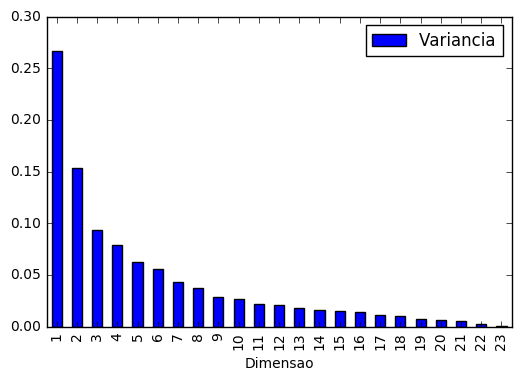

In [161]:
# Quantidade de variancia de cada componente principal
dimensoes = range(1,len(pca.components_)+1)
d = {'Variancia':pca.explained_variance_ratio_, 'Dimensao':dimensoes}
componentes = pd.DataFrame(d);

componentes.plot.bar(x='Dimensao',y='Variancia');

In [211]:
import matplotlib.pyplot as plt

# Principais atributos para cada componente
atributos_por_componente = pd.DataFrame(np.round(pca.components_, 4), columns = cbrt_gastos.keys())
atributos_por_componente.index = dimensoes
cor_area = ['g','g','g','g','g','g','g','g','b','b','b','b','b','b','r','r','r','r','r','r','r','r','r']

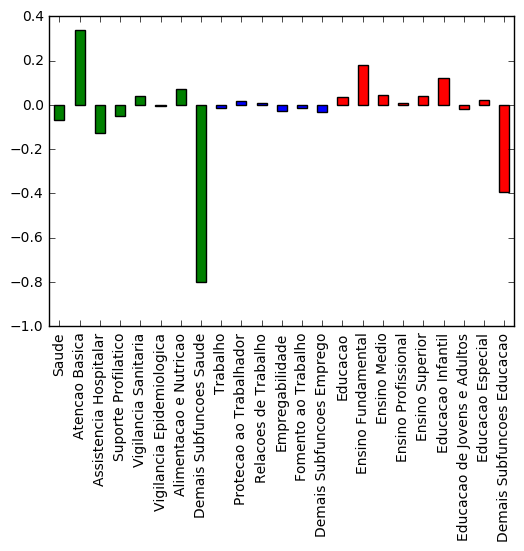

In [212]:
# Componente 1
atributos_por_componente.iloc[0,:].plot.bar(color=cor_area);

In [ ]:
# Componente 2
atributos_por_componente.iloc[1,:].plot.bar(color=cor_area);

In [ ]:
# Componente 3
atributos_por_componente.iloc[2,:].plot.bar(color=cor_area);

In [ ]:
# Componente 4
atributos_por_componente.iloc[3,:].plot.bar(color=cor_area);

## Maiores cidades por região

## Maiores cidades por UF